<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/NUIN443_ps6_HMM%2BLDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [190]:
import numpy as np
import matplotlib.pyplot as plt

#Some helper functions for Gaussians
from numpy.random import normal, multivariate_normal
from scipy.stats import norm

#Some scikit learn models we'll be using
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA,FactorAnalysis

#To load the data file
import pickle



## 1) Hidden Markov Models


A) Write code to simulate data from the an HMM with 2 discrete states (indexed by 0 and 1), with 1-dimensional Gaussian observations.
<br><br>
The initial state probabilities are:<br>
$P(z_0=0)=0.5$,
$P(z_0=1)=0.5$
<br><br>
The transitions matrix is:<br>
$A = \begin{bmatrix} 0.9 & 0.1 \\ 0.05 & 0.95 \end{bmatrix}$
<br><br>
The emissions probabilities are:<br>
$P(y|z=0)=\mathcal{N}(0,1)$
<br>
$P(y|z=1)=\mathcal{N}(2,1)$

<br><br>
We've provided code below that you can fill in (which should hopefully make this faster for you)

*Credit: Note that the below code has been adapted from Neuromatch's HMM exercise.*

In [191]:
## Fill in parameters below##

#Initial probabilities
initial_probs=[0.5, 0.5]

#Transition matrix
transition_matrix=np.array([[0.9, 0.1],[0.05, 0.95]])

#Means for the 2 states
means= [0,2]

#Variances for the 2 states
varz= [1,1]



#Number of time points to run the simulation for
T=500


#We'll set the random seed so results are reproducible
np.random.seed(0)

# Initialize the latent (Z) and observation (X)
Z = np.zeros((T,),dtype=int)
X = np.zeros((T,))



# Sample initial (time 0) latent state
## Fill in the line below##
Z[0] = np.random.choice([0,1],p= initial_probs)

# Given the latent that was just sampled, determine the observation at time 0
## Fill in the line below##
X[0] = normal(means[Z[0]], varz[Z[0]] )

# Loop over time points
# At each time point, sample the next latent state (based on the transition matrix and the previous state),
# and then determine the observation at that time point
for t in range(1,T):

  # Determine latent state at time `t`
  ## Fill in the line below##
  transition_vector = transition_matrix[Z[t-1],:]
  Z[t] = np.random.choice([0,1],p=transition_vector)

  #Given the latent that was just sampled, determine the observation at time t
  ## Fill in the line below##
  X[t] = normal(means[Z[t]], varz[Z[t]])

Run the code below to plot the latent (Z) and the observations (X)

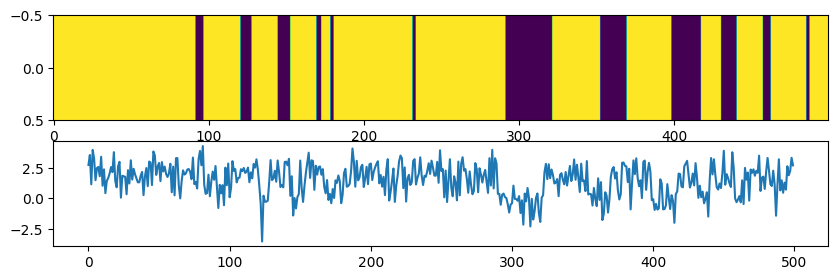

In [192]:
plt.figure(figsize=(10,3))

plt.subplot(2,1,1)
plt.imshow(Z[None,:],aspect='auto')

plt.subplot(2,1,2)
plt.plot(X)

B) Fit K-means to the observations. You can use sci-kit learn (imported above)

In [193]:
km = KMeans(n_clusters=2)
Z_kmeans = km.fit_predict(X.reshape(-1,1))

/home/diya/anaconda3/envs/mp_opto/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Run the below code to see how the states learned compare to the ground truth HMM states. Change "Z_kmeans" to the variable name of the kmeans states you used above.

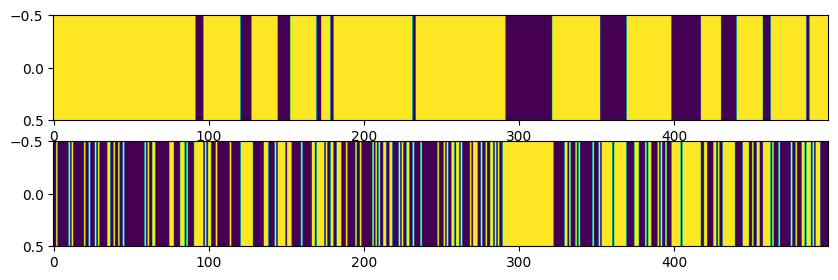

In [194]:
plt.figure(figsize=(10,3))

plt.subplot(2,1,1)
plt.imshow(Z[None,:],aspect='auto')

plt.subplot(2,1,2)
plt.imshow(Z_kmeans[None,:],aspect='auto')


C)Calculate the accuracy of K-means at finding the ground truth HMM states

In [197]:
Z_kmeans_flip = 1 - Z_kmeans# my kmeans categories are swapped for some reason
corrects = np.count_nonzero(Z_kmeans_flip== Z)
print(corrects / len(Z))

0.748


D) We are not going to have you code up the full EM algorithm, but will have you do most of the E step. This will involve the forward/backward algorithm. Assume that you know the HMM parameters (use the ground truth ones).<br>
Code up the forward algorithm for HMMs, and use it to calculate "alphas" for all time points.

In [198]:
def forward(X, pi, A, emit_means, emit_vars):
    #emissions tuple  = (means, variances)
    #lets first phis
    num_states = A.shape[0]
    num_observations = len(X)
    phi = np.empty((num_observations, num_states))
    for idx in np.arange(num_observations):
        for state in np.arange(num_states):
            phi[idx, state] = norm.pdf(X[idx], emit_means[state], emit_vars[state]) 
            
    alpha = np.empty((num_observations, num_states))
    init_temp = pi * phi[0,:]
    init_temp = init_temp / np.sum(init_temp)
    alpha[0,:] = init_temp
    
    for idx in np.arange(1, num_observations):
        temp = phi[idx,:] * (A.T @ alpha[idx-1,:])
        temp = temp / np.sum(temp)
        alpha[idx,:] = temp
    
    return alpha

In [199]:
pi = initial_probs
A = transition_matrix
emit_means = means
emit_vars = varz
alphas = forward(X, pi, A, emit_means, emit_vars)

Run the below code to see how the alphas compare to the ground truth HMM states. Change "alphas" to the variable name you used above. This is a good sanity check that the above code is correct, since the alphas for one of the states will look somewhat similar to the ground truth (although the values won't always be exactly 0 and 1).

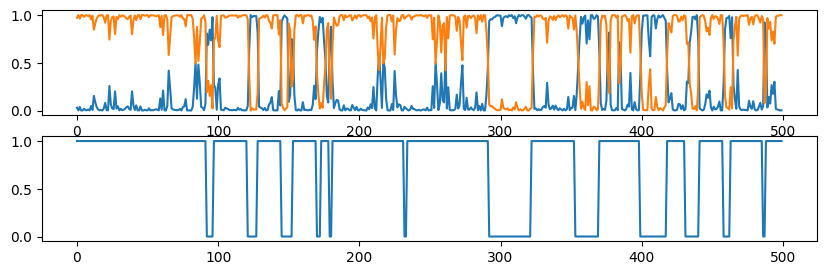

In [200]:
plt.figure(figsize=(10,3))

plt.subplot(2,1,1)
plt.plot(alphas)

plt.subplot(2,1,2)
plt.plot(Z)

E) Code up the backward algorithm for HMMs, and use it to calculate "betas" for all time points.

In [201]:
def backward(X, pi, A, emit_means, emit_vars):
    #emissions tuple  = (means, variances)
    #lets first phis
    num_states = A.shape[0]
    num_observations = len(X)
    phi = np.empty((num_observations, num_states))
    for idx in np.arange(num_observations):
        for state in np.arange(num_states):
            phi[idx, state] = norm.pdf(X[idx], emit_means[state], emit_vars[state]) 
            
            
    beta = np.empty((num_observations, num_states))
    beta[-1,:] = 1
    
    for idx in np.arange(num_observations-2, 0, -1):
        temp = A @ (phi[idx+1, :] * beta[idx+1,:])
        temp = temp / np.sum(temp)
        beta[idx,:] = temp
    
    return beta
    

In [202]:
pi = initial_probs
A = transition_matrix
emit_means = means
emit_vars = varz
betas = backward(X, pi, A, emit_means, emit_vars)

Run the below code to see how the betas compare to the ground truth HMM states. Change "betas" to the variable name you used above. This is a good sanity check that the above code is correct, since the betas for one of the states will look somewhat similar to the ground truth (although the values won't always be exactly 0 and 1 - in fact, for the betas, the values here will be between ~0.1 and 0.9).

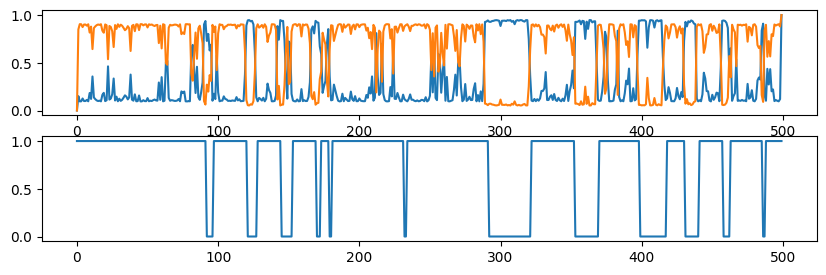

In [203]:
plt.figure(figsize=(10,3))

plt.subplot(2,1,1)
plt.plot(betas)

plt.subplot(2,1,2)
plt.plot(Z)

F) Run the forward/backward algorithm (combining the steps above) to get the posterior, p(z|x).

In [204]:
posterior = alphas * betas

Run the below code to see how the posterior compares to the ground truth HMM states. Change "posterior" to the variable name you used above.

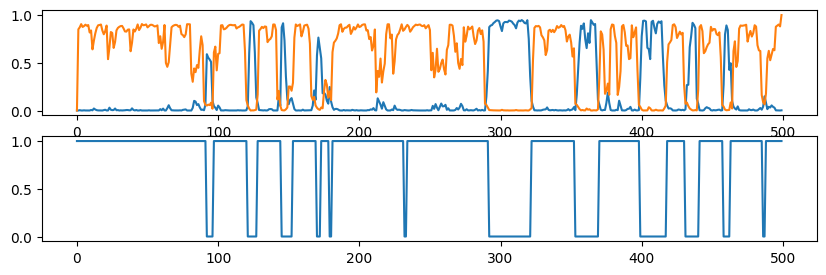

In [205]:
plt.figure(figsize=(10,3))

plt.subplot(2,1,1)
plt.plot(posterior)

plt.subplot(2,1,2)
plt.plot(Z)

G) Calculate the accuracy of the posterior at estimating the ground truth latent states. Set a probability threshold of 0.5 to determine which of the two states is more likely.

In [207]:
posterior_estimates = np.argmax(posterior, axis=1)
removes = np.max(posterior, axis=1) < 0.5 #get mask when threshold is less than .5
posterior_estimates[removes] = -1 #set all non-confident guesses to -1
acc = np.count_nonzero(posterior_estimates==Z) / len(Z)
print(f'accuracy of posterior:{acc}')

accuracy of posterior:0.808


H) In words, in the text box below, describe why the HMM led to more accurate results than fitting with K-means.

As a side note, this increase in accuracy is not just because we were cheating above and using the ground truth parameters. Fitting an HMM with EM gives similar results.

K-means essentially is just clustering based on the emissions, so that its really only learning the difference means of the two gaussians. However, an HMM learns transition probabilities, so it not only learns the emissions but it also learns the probability that the next timepoint is from a certain latent or not, leading to better accuracy.

## 2) Linear dynamical systems

We'll be using the ssm package for fitting linear dynamical systems. Run the code below to install that package.

In [208]:
#!pip install git+https://github.com/lindermanlab/ssm.git@master#egg=ssm

#import ssm

A) Fill in the code below to simulate data from a linear dynamical system model with 2-dimensional latents, with 5-dimensional observations.

<br>
The dynamics matrix is the scaled rotation matrix (which will cause the latents to spiral) :<br>
$A = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix} \text{for  } \theta=\pi/20$

<br><br>
In the code below, the emissions (observations) matrix is random, and there is more noise in the observations than the dynamics (see code below).


In [209]:
#Dimensionality of latents
K=2
#Dimensionality of observations
N=5

#Initial latent state
Z0=np.array([.5,.5])

#Dynamics matrix
th=np.pi/20
A = .995 * np.array([[np.cos(th),-np.sin(th)],[np.sin(th),np.cos(th)]])

#Noise of dynamics
Sig_dynamics=.0001*np.identity(K)

#Emissions (observations) matrix
C=np.random.randn(K,N)

#Noise of observations
Sig_observations=.01*np.identity(N)

#Number of time points to simulate for
T=500

#Initialize latents and observations
Z = np.zeros((T,K))
Y = np.zeros((T,N))

#Set initial state (at time 0) of the latents
Z[0]=Z0

#Update observations at time t according to the latent state
## FILL IN LINE BELOW ##
Y[0]=multivariate_normal(Z[0]@C,Sig_observations)
# Loop over time points
# At each time point, sample the next latent state (based on the dynamics matrix and the previous state),
# and then determine the observation at that time point
for t in range(1,T):
  #Update latent state at time t according to dynamics
  ## FILL IN LINE BELOW ##
  Z[t]=multivariate_normal(A@Z[t-1],Sig_dynamics)

  #Update observations at time t according to the latent state
  ## FILL IN LINE BELOW ##
  Y[t]=multivariate_normal(Z[t]@C,Sig_observations)

Run the code below to plot the two dimensions of the latent against each other (to see the spiral if the above simulation is correct)

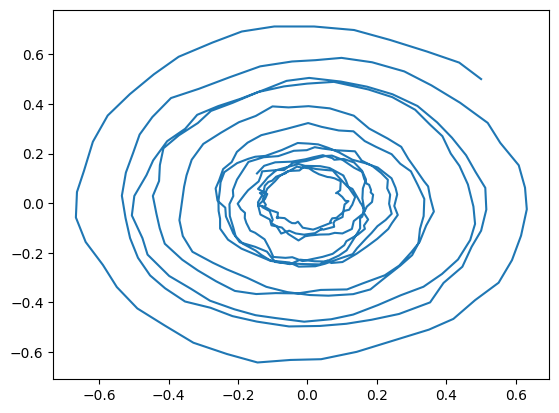

In [210]:
plt.plot(Z[:,0],Z[:,1])

Run the code below to plot the two dimensions of the latent as a function of time

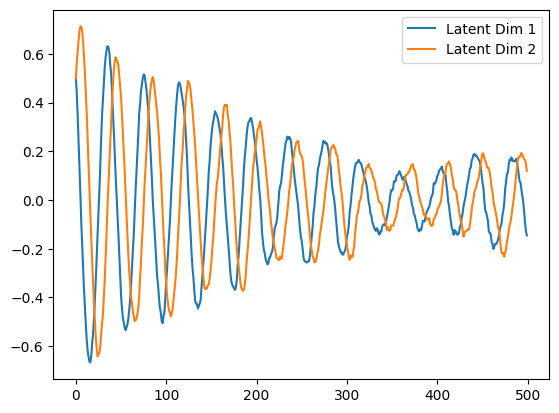

In [211]:
plt.plot(Z[:,0])
plt.plot(Z[:,1])
plt.legend(['Latent Dim 1','Latent Dim 2'])

Run the code below to plot the first two dimensions of the observations as a function of time

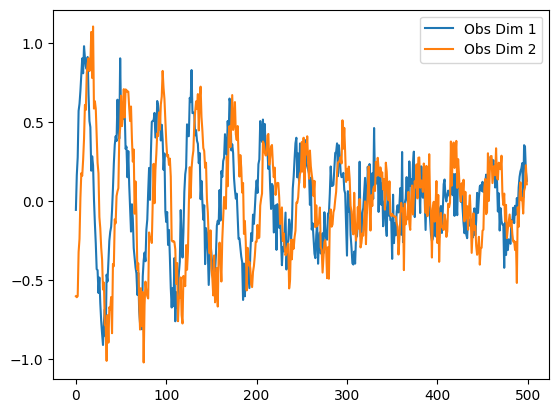

In [212]:
plt.plot(Y[:,0])
plt.plot(Y[:,1])
plt.legend(['Obs Dim 1','Obs Dim 2'])

B) Fit a factor analysis model (using sci-kit learn) with 2 latents to the above observations

In [213]:
fa=FactorAnalysis(2)
z_fa=fa.fit_transform(Y)

C) Plot the 2 factor analysis latents as a function of time

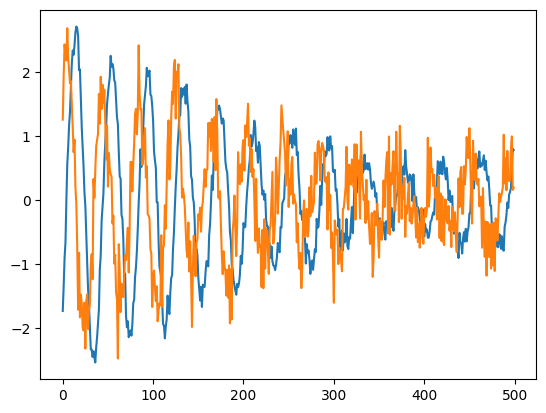

In [214]:
plt.plot(z_fa)

D) Fit an LDS model to the data

You can run the ssm code below (no need to make any changes). Still, read through the code/comments to try to generally understand the below code.

In [215]:
obs_dim=N
latent_dim=K

#Define an LDS model that has a Gaussian emissions model, with the correct latent and observation dimensions
lds = ssm.LDS(obs_dim, latent_dim, emissions="gaussian")

#Fit the LDS model using EM
#Note the method says 'laplace_em', which becomes standard EM with Gaussian emissions
elbos, q = lds.fit(Y, method="laplace_em", num_iters=10)

#The output q contains the posterior distribution (the latent's mean and variance)
#Below, we'll just extract the mean of the posterior at each time point (the value we usually think of as the latent):
z_lds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

E) Plot the latents learned by LDS

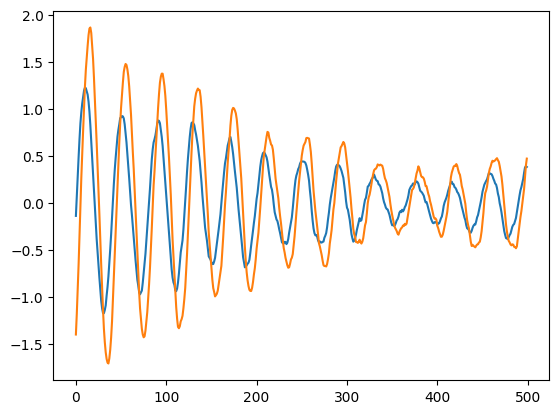

In [216]:
fig, ax = plt.subplots()
ax.plot(z_lds)

F) How do the learned latents differ between the factor analysis and LDS models? Why?  (Enter your answer in the text box below)

LDS learns a dynamics matrix, while FA doesn't learn how the current latent state is updated. Thus, FA learns noisier latents. 

G) Run the below code to check that the eigenvalues of the system's dynamics (the A matrix) were recovered correctly. Note that the eigenvectors, and the A matrices themselves won't be identical, because the emissions matrix can be recovered differently from the ground truth (e.g. some linear combination of the ground truth).

In [217]:
#Eigendecomposition of true dynamics
np.linalg.eig(A)

(array([0.9827499+0.15565229j, 0.9827499-0.15565229j]),
 array([[ 0.        -0.70710678j,  0.        +0.70710678j],
        [-0.70710678+0.j        , -0.70710678-0.j        ]]))

In [218]:
#Eigendecomposition of learned dynamics
np.linalg.eig(lds.dynamics.As)

(array([[0.97673554+0.15490013j, 0.97673554-0.15490013j]]),
 array([[[0.39972501+0.36666139j, 0.39972501-0.36666139j],
         [0.84010674+0.j        , 0.84010674-0.j        ]]]))